# Buoy localisation
We will use a Gaussian mixture model to localise the buoys.
A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

The non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.
Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters.

Variational Bayesian estimation of a Gaussian mixture.

This class allows to infer an approximate posterior distribution over the parameters of a Gaussian mixture distribution. The effective number of components can be inferred from the data

In [1]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
import sys; sys.path.append('../src/')
import bt_actions
import importlib
%matplotlib inline

In [2]:
# ground truth walls
lines = np.load('walls.npy')
points = np.vstack(lines)

In [3]:
# generate data
importlib.reload(bt_actions)
samples = bt_actions.A_ReadBuoys.generate_data(points=points, n_samples=500, sigma=1)
samples

array([[-4.25715652,  2.25583289, -1.51223481],
       [13.6005256 , -5.0153583 ,  0.32916343],
       [-8.71616193, -6.14942658, -1.70163158],
       ...,
       [-1.07381151, -5.49762576,  0.5834687 ],
       [ 9.01578573,  0.40437415, -0.1955589 ],
       [ 4.21067005, 13.91790768,  0.19603881]])

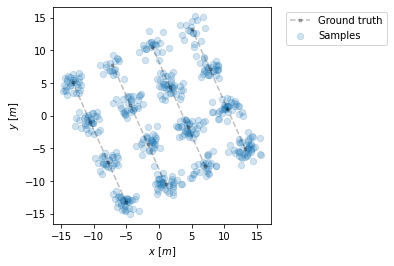

In [4]:
# plotting
importlib.reload(bt_actions)
fig, ax = bt_actions.A_ReadBuoys.plot(lines=lines, samples=samples)
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


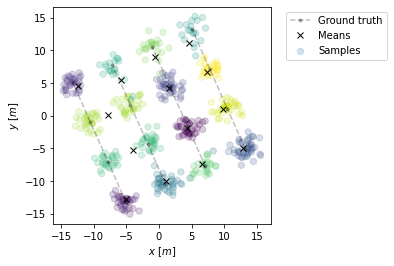

In [5]:
# clustering
importlib.reload(bt_actions)
mu, sigma, gsigma, labels, model = bt_actions.A_ReadBuoys.approximate(samples=samples, n_components=16)
fig, ax = bt_actions.A_ReadBuoys.plot(means=mu, samples=samples, lines=lines, c=labels)
plt.show()

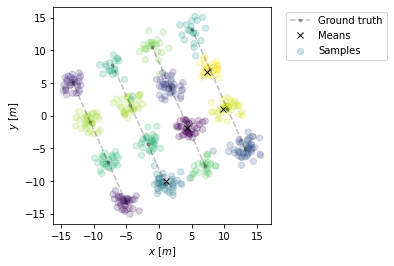

In [6]:
# filtering means based on generalized varaiance
importlib.reload(bt_actions)
sigma_tol = 15.0
fig, ax = bt_actions.A_ReadBuoys.plot(means=mu[gsigma<sigma_tol], samples=samples, lines=lines, c=labels)
plt.show()

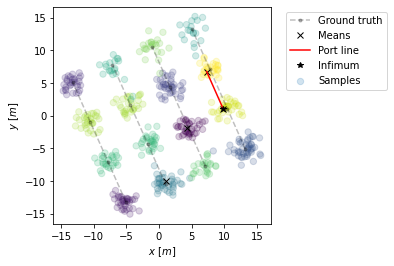

In [7]:
# inferring lines from the data given a priori theta=116 [deg] and n_lines=4
importlib.reload(bt_actions)
sample_lines = bt_actions.A_ReadBuoys.infer_lines(points=mu[gsigma<sigma_tol], theta=116, n_lines=4, atol=1e-2, dtol=1.0)
fig, ax = bt_actions.A_ReadBuoys.plot(means=mu[gsigma<sigma_tol], samples=samples, lines=lines, sample_lines=sample_lines, c=labels)
plt.show()


Number of samples: 100
Number of buoys approximated: 4
Number of certain buoys: 0
Number of lines infered: 0


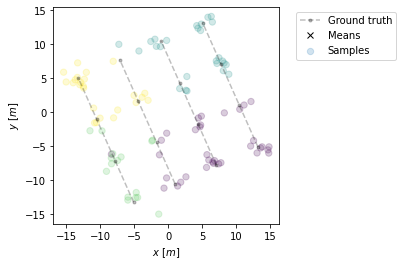

/usr/local/lib/python3.8/dist-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '

Number of samples: 100
Number of buoys approximated: 6
Number of certain buoys: 0
Number of lines infered: 0


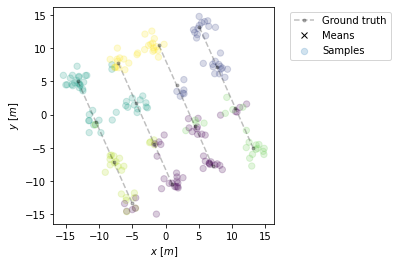


Number of samples: 100
Number of buoys approximated: 8
Number of certain buoys: 1
Number of lines infered: 0


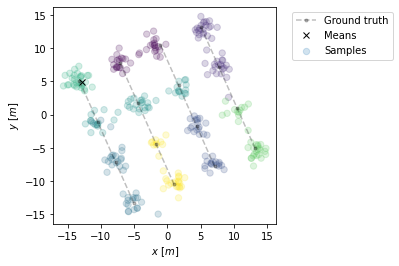


Number of samples: 100
Number of buoys approximated: 9
Number of certain buoys: 4
Number of lines infered: 0


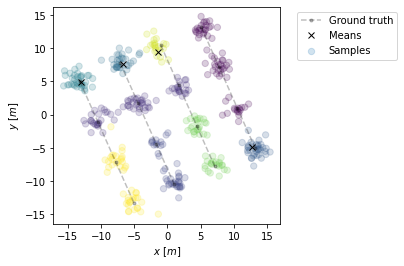

/usr/local/lib/python3.8/dist-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '

Number of samples: 100
Number of buoys approximated: 11
Number of certain buoys: 4
Number of lines infered: 0


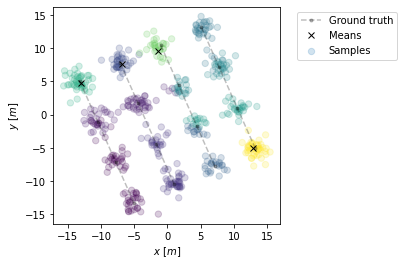


Number of samples: 100
Number of buoys approximated: 15
Number of certain buoys: 15
Number of lines infered: 4


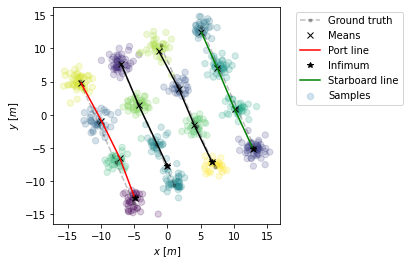


Number of samples: 100
Number of buoys approximated: 15
Number of certain buoys: 15
Number of lines infered: 4


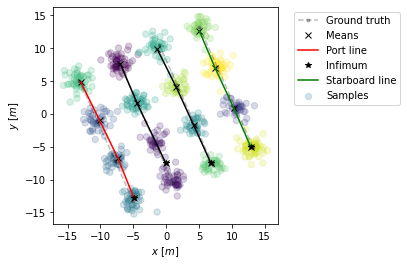


Number of samples: 100
Number of buoys approximated: 16
Number of certain buoys: 16
Number of lines infered: 4


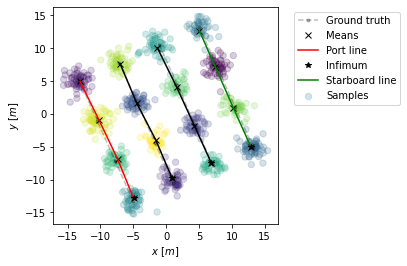


Number of samples: 100
Number of buoys approximated: 16
Number of certain buoys: 16
Number of lines infered: 4


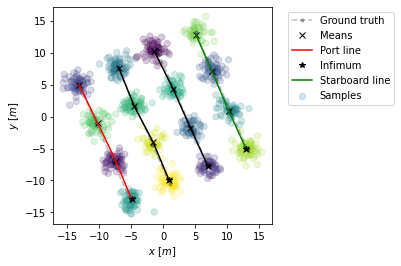


Number of samples: 100
Number of buoys approximated: 16
Number of certain buoys: 16
Number of lines infered: 4


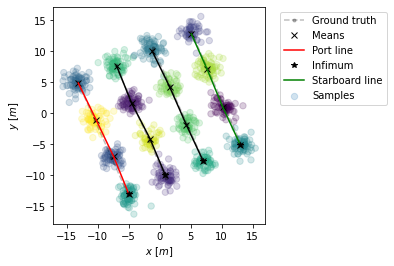

In [8]:
# let's put it all together...
importlib.reload(bt_actions)

# variance of sampling
sigma = 1.0
# number of buoys (a priori)
n_components = 16
# generalised variance tolerance
gsigma_tol = 5.0
# number of lines (a priori)
n_lines = 4
# line-angle tolerance
atol=1e-2
# line-inclusion distance tolerance
dtol=1e-2
# use trace
use_trace = True
# number of samples to taker per epoch
n_samples = 100
# number of epochs
epo = 10
# model
model = BayesianGaussianMixture(n_components=n_components, warm_start=True)

# loop through different number of samples,
# incrementally updating the Gaussian mixture model
samples = np.empty((0,3))
for _ in range(epo):

    # gather data
    sample = bt_actions.A_ReadBuoys.generate_data(
        points=points, 
        n_samples=n_samples, 
        sigma=sigma
    )
    samples = np.vstack((samples, sample))

    # localise buoys
    mu, covar, gsigma, labels, model = bt_actions.A_ReadBuoys.approximate(
        samples=samples, 
        n_components=n_components,
        use_trace=use_trace,
        model=None
    )

    # infer walls
    sample_lines = bt_actions.A_ReadBuoys.infer_lines(
        points=mu[gsigma<sigma_tol], 
        theta=116, 
        n_lines=4, 
        atol=1e-2, 
        dtol=1.0
    )
    
    # information
    print('')
    print('Number of samples: {}'.format(n_samples))
    print('Number of buoys approximated: {}'.format(mu.shape[0]))
    print('Number of certain buoys: {}'.format(mu[gsigma<sigma_tol].shape[0]))
    print('Number of lines infered: {}'.format(len(sample_lines)))

    # plot it
    fig, ax = bt_actions.A_ReadBuoys.plot(
        lines=lines,
        samples=samples,
        means=mu[gsigma<sigma_tol], 
        sample_lines=sample_lines, 
        c=labels
    )
    # fig.savefig('img/buoys_{}.png'.format(n_samples), dpi=1000, bbox_inches='tight')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

# Perimeter localisation plan

Alrighty, seems like the buoy localisation stuff above checks out.
Time to devise a path to follow to localise the buoys.
We will assume that we know the approximate location of
the centroid, as well as the orientation (as before).
We will also take a safe starting distance as an argument.

[]

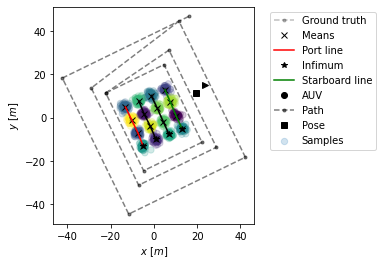

In [22]:
importlib.reload(bt_actions)

# it's also import to know which corner we're closet to
pose = np.random.uniform(low=0, high=2*np.pi)
pose = np.random.uniform(low=20, high=30)*np.array([np.cos(pose), np.sin(pose)])
pose = np.array([*pose, 0])

# make buoy localisation plan
direction = [4, 4]
path = bt_actions.A_SetBuoyLocalisationPlan.perimeter_plan(
    point=pose,
    origin=mu.mean(axis=0),
    angle=116,
    distances=[(30, 35), (20, 25), (15, 20)],
    direction=direction
)

# plot it
fig, ax = bt_actions.A_ReadBuoys.plot(
    lines=lines,
    samples=samples,
    means=mu[gsigma<sigma_tol], 
    sample_lines=sample_lines, 
    ref_point=pose,
    path=path,
    c=labels
)
ax.plot(pose[0], pose[1], 'ks', label='Pose')
vec = pose[:2] + direction
ax.plot(vec[0], vec[1], 'k>')
ax.legend(bbox_to_anchor=(1.05, 1))
plt.plot()

[]

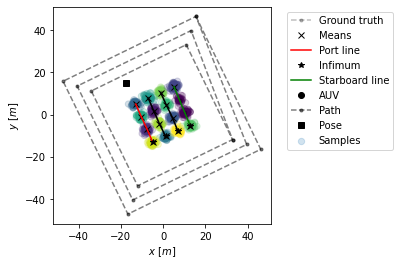

In [38]:

# make a plan
# perims = bt_actions.A_SetBuoyLocalisationPlan.closest_side(pose, centroid, 116)
# ax.plot(perims[0,0], perims[0,1], 'ko')
# # ax.plot(perims[1,0], perims[1,1], 'k^')
# for i in range(4):
#     ax.plot(perims[i,:,0], perims[i,:,1])

In [42]:
lines = {'frame_id': 'map', 'walls': [np.array([[-5.,  4., -0.],
           [-5.,  9., -0.],
           [-5., 14., -0.]]), np.array([[ 5.,  4., -0.],
           [ 5.,  9., -0.],
           [ 5., 14., -0.]])]}['walls']
# a = np.vstack(a)
# np.linalg.norm(a - a.mean(axis=0), axis=1).max()

In [50]:
lines[-1][-1] - lines[0][0]

array([10., 10.,  0.])

In [ ]:
lines[0][-1] - lines[0][0]

In [41]:
centroid = np.vstack(a).mean(axis=0)
yrange = a[0][0] - centroid
# yrange = np.linalg.norm(yrange)
print(yrange)
yrange = a[0][-1] - centroid
yrange = np.linalg.norm(yrange)
print(yrange    )

[-5. -5. -0.]
7.0710678118654755


In [ ]:
yrange = a[0][0] - centroid
yrange = np.linalg.norm(yrange)
print(yrange)
yrange = a[0][-1] - centroid
yrange = np.linalg.norm(yrange)
print(yrange    )

In [53]:
utmc = np.load('../src/utm_centroid.npy')

In [56]:
! echo $utmc

[ 6.43799559e+05 6.45926197e+06 -3.31695458e-01]


In [75]:
import rospy
from smarc_msgs.srv import UTMToLatLon    
from smarc_msgs.srv import LatLonToUTM
from geometry_msgs.msg import Point

In [76]:
f = rospy.ServiceProxy('/sam/dr/utm_to_lat_lon', UTMToLatLon)

In [77]:
p = Point(
    *utmc
)
p

x: 643799.5586760626
y: 6459261.974485306
z: -0.3316954576173627

In [81]:
latlon = f(p)
latlon

lat_lon_point: 
  latitude: 58.25092211987216
  longitude: 11.45027244508583
  altitude: -0.3316954576173627

In [80]:
latlon.lat_lon_point.latitude

58.25092211987216

In [82]:
np.save(
    '../test/buoys_centroid_latlon',
    np.array([
        latlon.lat_lon_point.latitude,
        latlon.lat_lon_point.longitude
    ])
)

In [83]:
np.load('../test/buoys_centroid_latlon.npy')

array([58.25092212, 11.45027245])